In [1]:
import numpy as np
import math
import random
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers as opt
import tensorflow.keras.layers as lr
import tensorflow.keras.metrics as metrics
from   tensorflow.keras.models import Sequential

import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

print("Imported packages.")
print(tf.__version__)

Imported packages.
2.1.0


# Loading data

## Loading the data generated through simulation

In [2]:
X_data_step1_terran = np.load(os.path.join("data", "MergedData", "terranBotInputData.npy"))
print("Loaded training data.")
print("X_data shape:", X_data_step1_terran.shape)

X_data_step1_zerg = np.load(os.path.join("data", "MergedData", "zergBotInputData.npy"))
print("Loaded training data.")
print("X_data shape:", X_data_step1_zerg.shape)

Y_data = np.load(os.path.join("data", "MergedData", "OutputData.npy"))

Loaded training data.
X_data shape: (10194, 33)
Loaded training data.
X_data shape: (10194, 23)


In [3]:
X_data_step1_terran, X_data_step1_zerg, Y_data = sk.utils.shuffle(X_data_step1_terran, X_data_step1_zerg, Y_data, random_state=0)
print("Shuffled data.")

Shuffled data.


## Defining step2 model

This model takes the units from the Terran, and returns the Zerg units requiered to beat them.

That said, it will take an input array of shape 14 (33-5 for upgrades, divided by 2 as we don't need to give health information), and will return an output array of shape 9.

In [4]:
def create_model(input_shape, output_shape):
    model = Sequential([
        lr.Dense(units=input_shape, activation='relu', input_dim=input_shape),
        lr.Flatten(),
        lr.Dropout(0.2),
        lr.Dense(units=28, activation='relu'),
        lr.Dropout(0.2),
        lr.Dense(units=14, activation='relu'),
        lr.Dropout(0.2),
        lr.Dense(units=10, activation='relu'),
        lr.Dense(units=output_shape, activation='softmax')
    ])

    model.compile(optimizer=opt.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0000001),
              loss="mean_squared_error",
              metrics=['accuracy'])
    return model

In [5]:
model = create_model(14, 9)

# Filtering data

In [6]:
from numba import jit

@jit
def format_array_to_step2(array):
    croped = array[:-5:]
    out = np.zeros((int(croped.shape[0]/2), ), dtype=np.float32)
    for i in range(len(out)):
        out[i] = croped[2*i]
    return out

@jit
def format_array_to_step1(array):
    out = np.zeros((array.shape[0]*2+5, ), dtype=np.float32)
    for i in range(len(array)):
        out[2*i] = array[i]
        out[2*i +1 ] = 0. if array[i] == 0 else 1.
    for i in range(5):
        out[-i] = 1 # We assume that units are not upgraded
    return out

@jit
def format_data_to_step2(data):
    out = np.zeros((data.shape[0], int((data.shape[1]-5)/2)), dtype=np.float32)
    for i in range(len(data)):
       out[i] = format_array_to_step2(data[i])
    return out

@jit
def format_data_to_step1(data):
    out = np.zeros((data.shape[0], (data.shape[1]*2)+5), dtype=np.float32)
    for i in range(len(data)):
       out[i] = format_array_to_step1(data[i])
    return out

In [7]:
# Testing format_data_to_step2
X_data_step2_terran = format_data_to_step2(X_data_step1_terran)
print(X_data_step2_terran.shape)
print(X_data_step1_terran[0])
print(X_data_step2_terran[0])

# Testing format_data_to_step1
X_data_step1_bk_terran = format_data_to_step1(X_data_step2_terran)
print(X_data_step1_bk_terran.shape)
print(X_data_step1_bk_terran[0])
print(X_data_step2_terran[0])
del X_data_step1_bk_terran

(10194, 14)
[ 1.  1. 22.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  2.  2.  2.  2.  2.]
[ 1. 22.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
(10194, 33)
[ 1.  1. 22.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.]
[ 1. 22.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [8]:
X_data_step2_terran = format_data_to_step2(X_data_step1_terran)
X_data_step2_zerg = format_data_to_step2(X_data_step1_zerg)

In [9]:
from scipy.special import softmax

def keep_won_fights(X_Terran, X_Zerg, Y, threshold=0.5):
    assert len(X_Terran) == len(X_Zerg) and len(X_Zerg) == len(Y)
    X_Terran_out, X_Zerg_out = [], []
    for i in range(len(X_Terran)):
        if Y[i] > threshold:
            X_Terran_out.append(X_Terran[i])
            X_Zerg_out.append(X_Zerg[i])
    return np.array(X_Terran_out, dtype=np.float32), np.array(X_Zerg_out, dtype=np.float32)

def softmax_array(array):
    for i in range(len(array)):
        array[i] = softmax(array[i])
    return array

In [10]:
X_Terran, X_Zerg = keep_won_fights(X_data_step2_terran, X_data_step2_zerg, Y_data, 0.5)
X_Zerg = softmax_array(X_Zerg)
print(X_Terran.shape)
print(X_Zerg.shape)

(2444, 14)
(2444, 9)


In [11]:
TRAIN_PROPORTION = 0.8
split_index = int((len(X_Terran)-1)*TRAIN_PROPORTION)
splited_X_data = np.split(X_Terran, [split_index, len(X_Terran)])
splited_Y_data = np.split(X_Zerg, [split_index, len(X_Zerg)])

X_Terran, X_Terran_test = splited_X_data[0], splited_X_data[1]
Y_Zerg, Y_Zerg_test = splited_Y_data[0], splited_Y_data[1]
print("Splitted data into training and testing sets.")
print("X_Terran shape:", X_Terran.shape)
print("Y_Zerg shape:", Y_Zerg.shape)
print("X_Terran_test shape:", X_Terran_test.shape)
print("Y_Zerg_test shape:", Y_Zerg_test.shape)

Splitted data into training and testing sets.
X_Terran shape: (1954, 14)
Y_Zerg shape: (1954, 9)
X_Terran_test shape: (490, 14)
Y_Zerg_test shape: (490, 9)


## Training a model without reinforcement learning

In [12]:
NB_EPOCHS = 2500
BATCH_SIZE = 500

In [13]:
# Training Model on GPU if available
list_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(list_devices))
print("Using GPU: ", list_devices[0] if len(list_devices) > 0 else False)

Num GPUs Available:  1
Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [14]:
# Training model_tilte_1
device = tf.device('/GPU:0') if len(list_devices) > 0 else tf.device('/CPU:0')
with tf.device('/GPU:0'):
    history = model.fit(X_Terran, Y_Zerg,
                        epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_Terran_test, Y_Zerg_test),
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=1000,
                                                        restore_best_weights=True)])

Train on 1954 samples, validate on 490 samples
Epoch 1/2500
1954/1954 [==============================] - 0s 225us/sample - loss: 0.0909 - accuracy: 0.1965 - val_loss: 0.0865 - val_accuracy: 0.2469
Epoch 2/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0879 - accuracy: 0.2108 - val_loss: 0.0855 - val_accuracy: 0.2510
Epoch 3/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0865 - accuracy: 0.2165 - val_loss: 0.0846 - val_accuracy: 0.2531
Epoch 4/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0849 - accuracy: 0.2339 - val_loss: 0.0837 - val_accuracy: 0.2592
Epoch 5/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0845 - accuracy: 0.2492 - val_loss: 0.0828 - val_accuracy: 0.2755
Epoch 6/2500
1954/1954 [==============================] - 0s 9us/sample - loss: 0.0839 - accuracy: 0.2794 - val_loss: 0.0820 - val_accuracy: 0.3041
Epoch 7/2500
1954/1954 [==============================] - 0s 7u

Epoch 56/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0706 - accuracy: 0.4458 - val_loss: 0.0709 - val_accuracy: 0.4286
Epoch 57/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0709 - accuracy: 0.4452 - val_loss: 0.0708 - val_accuracy: 0.4286
Epoch 58/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0706 - accuracy: 0.4519 - val_loss: 0.0707 - val_accuracy: 0.4286
Epoch 59/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0700 - accuracy: 0.4519 - val_loss: 0.0706 - val_accuracy: 0.4306
Epoch 60/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0709 - accuracy: 0.4493 - val_loss: 0.0705 - val_accuracy: 0.4286
Epoch 61/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0704 - accuracy: 0.4473 - val_loss: 0.0704 - val_accuracy: 0.4265
Epoch 62/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0698 - accuracy: 0.4509

Epoch 111/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0658 - accuracy: 0.4698 - val_loss: 0.0676 - val_accuracy: 0.4531
Epoch 112/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0664 - accuracy: 0.4724 - val_loss: 0.0676 - val_accuracy: 0.4531
Epoch 113/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0668 - accuracy: 0.4749 - val_loss: 0.0675 - val_accuracy: 0.4531
Epoch 114/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0669 - accuracy: 0.4580 - val_loss: 0.0675 - val_accuracy: 0.4551
Epoch 115/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0656 - accuracy: 0.4734 - val_loss: 0.0675 - val_accuracy: 0.4510
Epoch 116/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0659 - accuracy: 0.4719 - val_loss: 0.0675 - val_accuracy: 0.4510
Epoch 117/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0666 - accuracy:

1954/1954 [==============================] - 0s 7us/sample - loss: 0.0644 - accuracy: 0.4831 - val_loss: 0.0668 - val_accuracy: 0.4694
Epoch 166/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0650 - accuracy: 0.4724 - val_loss: 0.0668 - val_accuracy: 0.4714
Epoch 167/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0647 - accuracy: 0.4831 - val_loss: 0.0668 - val_accuracy: 0.4694
Epoch 168/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0644 - accuracy: 0.4841 - val_loss: 0.0668 - val_accuracy: 0.4694
Epoch 169/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0646 - accuracy: 0.4867 - val_loss: 0.0668 - val_accuracy: 0.4735
Epoch 170/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0651 - accuracy: 0.4806 - val_loss: 0.0668 - val_accuracy: 0.4735
Epoch 171/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0648 - accuracy: 0.4759 - val_l

Epoch 220/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0640 - accuracy: 0.4831 - val_loss: 0.0661 - val_accuracy: 0.4796
Epoch 221/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0636 - accuracy: 0.4780 - val_loss: 0.0661 - val_accuracy: 0.4796
Epoch 222/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0636 - accuracy: 0.4872 - val_loss: 0.0661 - val_accuracy: 0.4796
Epoch 223/2500
1954/1954 [==============================] - 0s 8us/sample - loss: 0.0639 - accuracy: 0.4826 - val_loss: 0.0661 - val_accuracy: 0.4796
Epoch 224/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0635 - accuracy: 0.4898 - val_loss: 0.0661 - val_accuracy: 0.4796
Epoch 225/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0637 - accuracy: 0.4846 - val_loss: 0.0661 - val_accuracy: 0.4755
Epoch 226/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0636 - accuracy:

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0641 - accuracy: 0.4780 - val_loss: 0.0659 - val_accuracy: 0.4796
Epoch 275/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0631 - accuracy: 0.4846 - val_loss: 0.0659 - val_accuracy: 0.4837
Epoch 276/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0634 - accuracy: 0.4887 - val_loss: 0.0659 - val_accuracy: 0.4837
Epoch 277/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0638 - accuracy: 0.4913 - val_loss: 0.0658 - val_accuracy: 0.4837
Epoch 278/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0633 - accuracy: 0.4821 - val_loss: 0.0658 - val_accuracy: 0.4837
Epoch 279/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0633 - accuracy: 0.4806 - val_loss: 0.0658 - val_accuracy: 0.4816
Epoch 280/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0628 - accuracy: 0.4852 - val_l

Epoch 329/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0624 - accuracy: 0.4954 - val_loss: 0.0658 - val_accuracy: 0.4816
Epoch 330/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0628 - accuracy: 0.4841 - val_loss: 0.0658 - val_accuracy: 0.4816
Epoch 331/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0628 - accuracy: 0.4990 - val_loss: 0.0658 - val_accuracy: 0.4816
Epoch 332/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0624 - accuracy: 0.4933 - val_loss: 0.0658 - val_accuracy: 0.4816
Epoch 333/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0624 - accuracy: 0.4928 - val_loss: 0.0657 - val_accuracy: 0.4796
Epoch 334/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0627 - accuracy: 0.4913 - val_loss: 0.0657 - val_accuracy: 0.4796
Epoch 335/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0630 - accuracy:

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0626 - accuracy: 0.4877 - val_loss: 0.0655 - val_accuracy: 0.4816
Epoch 384/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0623 - accuracy: 0.4918 - val_loss: 0.0655 - val_accuracy: 0.4796
Epoch 385/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0628 - accuracy: 0.4923 - val_loss: 0.0656 - val_accuracy: 0.4796
Epoch 386/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0619 - accuracy: 0.4903 - val_loss: 0.0656 - val_accuracy: 0.4796
Epoch 387/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0623 - accuracy: 0.4903 - val_loss: 0.0657 - val_accuracy: 0.4776
Epoch 388/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0617 - accuracy: 0.5010 - val_loss: 0.0657 - val_accuracy: 0.4776
Epoch 389/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0623 - accuracy: 0.4944 - val_l

Epoch 438/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0613 - accuracy: 0.4949 - val_loss: 0.0656 - val_accuracy: 0.4776
Epoch 439/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0619 - accuracy: 0.4969 - val_loss: 0.0655 - val_accuracy: 0.4816
Epoch 440/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0622 - accuracy: 0.4980 - val_loss: 0.0656 - val_accuracy: 0.4776
Epoch 441/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0619 - accuracy: 0.4903 - val_loss: 0.0656 - val_accuracy: 0.4796
Epoch 442/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0621 - accuracy: 0.4923 - val_loss: 0.0656 - val_accuracy: 0.4796
Epoch 443/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0614 - accuracy: 0.5036 - val_loss: 0.0656 - val_accuracy: 0.4776
Epoch 444/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0619 - accuracy:

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0617 - accuracy: 0.4990 - val_loss: 0.0654 - val_accuracy: 0.4816
Epoch 493/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0613 - accuracy: 0.5000 - val_loss: 0.0654 - val_accuracy: 0.4837
Epoch 494/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0617 - accuracy: 0.4928 - val_loss: 0.0654 - val_accuracy: 0.4837
Epoch 495/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0609 - accuracy: 0.5056 - val_loss: 0.0654 - val_accuracy: 0.4878
Epoch 496/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0618 - accuracy: 0.4995 - val_loss: 0.0653 - val_accuracy: 0.4878
Epoch 497/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0619 - accuracy: 0.5010 - val_loss: 0.0653 - val_accuracy: 0.4898
Epoch 498/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0617 - accuracy: 0.4944 - val_l

Epoch 547/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0616 - accuracy: 0.5000 - val_loss: 0.0652 - val_accuracy: 0.4857
Epoch 548/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0615 - accuracy: 0.5036 - val_loss: 0.0652 - val_accuracy: 0.4878
Epoch 549/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0614 - accuracy: 0.5082 - val_loss: 0.0651 - val_accuracy: 0.4857
Epoch 550/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0617 - accuracy: 0.4954 - val_loss: 0.0651 - val_accuracy: 0.4857
Epoch 551/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0622 - accuracy: 0.4913 - val_loss: 0.0650 - val_accuracy: 0.4837
Epoch 552/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0614 - accuracy: 0.4995 - val_loss: 0.0650 - val_accuracy: 0.4837
Epoch 553/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0610 - accuracy:

1954/1954 [==============================] - 0s 8us/sample - loss: 0.0611 - accuracy: 0.5072 - val_loss: 0.0651 - val_accuracy: 0.4857
Epoch 602/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0610 - accuracy: 0.4969 - val_loss: 0.0650 - val_accuracy: 0.4857
Epoch 603/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0612 - accuracy: 0.4969 - val_loss: 0.0650 - val_accuracy: 0.4878
Epoch 604/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0615 - accuracy: 0.4913 - val_loss: 0.0650 - val_accuracy: 0.4857
Epoch 605/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0604 - accuracy: 0.5020 - val_loss: 0.0651 - val_accuracy: 0.4878
Epoch 606/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0609 - accuracy: 0.5000 - val_loss: 0.0652 - val_accuracy: 0.4878
Epoch 607/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0613 - accuracy: 0.4985 - val_l

Epoch 656/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0609 - accuracy: 0.4995 - val_loss: 0.0651 - val_accuracy: 0.4898
Epoch 657/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0612 - accuracy: 0.4995 - val_loss: 0.0651 - val_accuracy: 0.4878
Epoch 658/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0612 - accuracy: 0.4928 - val_loss: 0.0651 - val_accuracy: 0.4857
Epoch 659/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0608 - accuracy: 0.4985 - val_loss: 0.0652 - val_accuracy: 0.4898
Epoch 660/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0610 - accuracy: 0.5036 - val_loss: 0.0652 - val_accuracy: 0.4898
Epoch 661/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0608 - accuracy: 0.4974 - val_loss: 0.0652 - val_accuracy: 0.4918
Epoch 662/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy:

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0611 - accuracy: 0.4980 - val_loss: 0.0649 - val_accuracy: 0.4878
Epoch 711/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0609 - accuracy: 0.4974 - val_loss: 0.0649 - val_accuracy: 0.4878
Epoch 712/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.5102 - val_loss: 0.0650 - val_accuracy: 0.4898
Epoch 713/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0615 - accuracy: 0.5026 - val_loss: 0.0651 - val_accuracy: 0.4878
Epoch 714/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.5046 - val_loss: 0.0650 - val_accuracy: 0.4878
Epoch 715/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0610 - accuracy: 0.4836 - val_loss: 0.0650 - val_accuracy: 0.4939
Epoch 716/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0607 - accuracy: 0.5061 - val_l

Epoch 765/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0614 - accuracy: 0.4887 - val_loss: 0.0652 - val_accuracy: 0.4878
Epoch 766/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0607 - accuracy: 0.4985 - val_loss: 0.0651 - val_accuracy: 0.4918
Epoch 767/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0604 - accuracy: 0.5077 - val_loss: 0.0651 - val_accuracy: 0.4959
Epoch 768/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.5000 - val_loss: 0.0651 - val_accuracy: 0.4939
Epoch 769/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.4969 - val_loss: 0.0651 - val_accuracy: 0.4939
Epoch 770/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.5015 - val_loss: 0.0651 - val_accuracy: 0.4959
Epoch 771/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0608 - accuracy:

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0603 - accuracy: 0.4969 - val_loss: 0.0651 - val_accuracy: 0.4959
Epoch 820/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0608 - accuracy: 0.5041 - val_loss: 0.0652 - val_accuracy: 0.4898
Epoch 821/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0604 - accuracy: 0.5072 - val_loss: 0.0651 - val_accuracy: 0.4918
Epoch 822/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0607 - accuracy: 0.5067 - val_loss: 0.0650 - val_accuracy: 0.4959
Epoch 823/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0604 - accuracy: 0.5026 - val_loss: 0.0650 - val_accuracy: 0.5000
Epoch 824/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0604 - accuracy: 0.5087 - val_loss: 0.0650 - val_accuracy: 0.5000
Epoch 825/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.5164 - val_l

Epoch 874/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0599 - accuracy: 0.5092 - val_loss: 0.0651 - val_accuracy: 0.4898
Epoch 875/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy: 0.4995 - val_loss: 0.0650 - val_accuracy: 0.4898
Epoch 876/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0603 - accuracy: 0.5015 - val_loss: 0.0650 - val_accuracy: 0.4898
Epoch 877/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy: 0.5005 - val_loss: 0.0650 - val_accuracy: 0.4878
Epoch 878/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.5036 - val_loss: 0.0650 - val_accuracy: 0.4857
Epoch 879/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0607 - accuracy: 0.5087 - val_loss: 0.0651 - val_accuracy: 0.4837
Epoch 880/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy:

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0598 - accuracy: 0.5113 - val_loss: 0.0652 - val_accuracy: 0.4857
Epoch 929/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy: 0.5051 - val_loss: 0.0651 - val_accuracy: 0.4918
Epoch 930/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0608 - accuracy: 0.5072 - val_loss: 0.0651 - val_accuracy: 0.4898
Epoch 931/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy: 0.5061 - val_loss: 0.0650 - val_accuracy: 0.4939
Epoch 932/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0604 - accuracy: 0.5051 - val_loss: 0.0649 - val_accuracy: 0.4959
Epoch 933/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0601 - accuracy: 0.5097 - val_loss: 0.0649 - val_accuracy: 0.4959
Epoch 934/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0600 - accuracy: 0.5159 - val_l

Epoch 983/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0603 - accuracy: 0.5036 - val_loss: 0.0650 - val_accuracy: 0.4857
Epoch 984/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0601 - accuracy: 0.4954 - val_loss: 0.0649 - val_accuracy: 0.4857
Epoch 985/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy: 0.5056 - val_loss: 0.0648 - val_accuracy: 0.4857
Epoch 986/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0598 - accuracy: 0.5056 - val_loss: 0.0648 - val_accuracy: 0.4837
Epoch 987/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0597 - accuracy: 0.5123 - val_loss: 0.0648 - val_accuracy: 0.4857
Epoch 988/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0604 - accuracy: 0.5056 - val_loss: 0.0649 - val_accuracy: 0.4857
Epoch 989/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0603 - accuracy:

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0597 - accuracy: 0.5061 - val_loss: 0.0648 - val_accuracy: 0.4918
Epoch 1038/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy: 0.5031 - val_loss: 0.0648 - val_accuracy: 0.4918
Epoch 1039/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0600 - accuracy: 0.5077 - val_loss: 0.0649 - val_accuracy: 0.4878
Epoch 1040/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0595 - accuracy: 0.5097 - val_loss: 0.0649 - val_accuracy: 0.4878
Epoch 1041/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0602 - accuracy: 0.5087 - val_loss: 0.0650 - val_accuracy: 0.4857
Epoch 1042/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5235 - val_loss: 0.0650 - val_accuracy: 0.4857
Epoch 1043/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0598 - accuracy: 0.5020 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0596 - accuracy: 0.5169 - val_loss: 0.0650 - val_accuracy: 0.4878
Epoch 1092/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0599 - accuracy: 0.5061 - val_loss: 0.0650 - val_accuracy: 0.4837
Epoch 1093/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0602 - accuracy: 0.5056 - val_loss: 0.0650 - val_accuracy: 0.4878
Epoch 1094/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0589 - accuracy: 0.5102 - val_loss: 0.0651 - val_accuracy: 0.4898
Epoch 1095/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0597 - accuracy: 0.5189 - val_loss: 0.0651 - val_accuracy: 0.4918
Epoch 1096/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0596 - accuracy: 0.5067 - val_loss: 0.0652 - val_accuracy: 0.4918
Epoch 1097/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0606 - accuracy: 0.5077 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0595 - accuracy: 0.5041 - val_loss: 0.0650 - val_accuracy: 0.4959
Epoch 1146/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0598 - accuracy: 0.5067 - val_loss: 0.0651 - val_accuracy: 0.4980
Epoch 1147/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0602 - accuracy: 0.5046 - val_loss: 0.0651 - val_accuracy: 0.4980
Epoch 1148/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5184 - val_loss: 0.0652 - val_accuracy: 0.4980
Epoch 1149/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0594 - accuracy: 0.5051 - val_loss: 0.0652 - val_accuracy: 0.4980
Epoch 1150/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0605 - accuracy: 0.4959 - val_loss: 0.0652 - val_accuracy: 0.4980
Epoch 1151/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0599 - accuracy: 0.5128 -

1954/1954 [==============================] - 0s 7us/sample - loss: 0.0601 - accuracy: 0.5261 - val_loss: 0.0654 - val_accuracy: 0.4980
Epoch 1200/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5230 - val_loss: 0.0654 - val_accuracy: 0.4980
Epoch 1201/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0594 - accuracy: 0.5154 - val_loss: 0.0654 - val_accuracy: 0.5000
Epoch 1202/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0597 - accuracy: 0.5087 - val_loss: 0.0653 - val_accuracy: 0.5000
Epoch 1203/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0595 - accuracy: 0.5123 - val_loss: 0.0652 - val_accuracy: 0.5000
Epoch 1204/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0600 - accuracy: 0.5154 - val_loss: 0.0652 - val_accuracy: 0.5000
Epoch 1205/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0597 - accuracy: 0.5092 -

1954/1954 [==============================] - 0s 7us/sample - loss: 0.0595 - accuracy: 0.4959 - val_loss: 0.0653 - val_accuracy: 0.4980
Epoch 1254/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0592 - accuracy: 0.5194 - val_loss: 0.0653 - val_accuracy: 0.4980
Epoch 1255/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5184 - val_loss: 0.0653 - val_accuracy: 0.4959
Epoch 1256/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0599 - accuracy: 0.5113 - val_loss: 0.0653 - val_accuracy: 0.4980
Epoch 1257/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5159 - val_loss: 0.0654 - val_accuracy: 0.4959
Epoch 1258/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0599 - accuracy: 0.5179 - val_loss: 0.0655 - val_accuracy: 0.4980
Epoch 1259/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0598 - accuracy: 0.5077 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0590 - accuracy: 0.5107 - val_loss: 0.0654 - val_accuracy: 0.4939
Epoch 1308/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5200 - val_loss: 0.0654 - val_accuracy: 0.4959
Epoch 1309/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0596 - accuracy: 0.5123 - val_loss: 0.0654 - val_accuracy: 0.4959
Epoch 1310/2500
1954/1954 [==============================] - 0s 5us/sample - loss: 0.0594 - accuracy: 0.5251 - val_loss: 0.0654 - val_accuracy: 0.4918
Epoch 1311/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5179 - val_loss: 0.0654 - val_accuracy: 0.4898
Epoch 1312/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5174 - val_loss: 0.0654 - val_accuracy: 0.4959
Epoch 1313/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0597 - accuracy: 0.5107 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5210 - val_loss: 0.0652 - val_accuracy: 0.4939
Epoch 1362/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0595 - accuracy: 0.5184 - val_loss: 0.0652 - val_accuracy: 0.4898
Epoch 1363/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0595 - accuracy: 0.5194 - val_loss: 0.0653 - val_accuracy: 0.4918
Epoch 1364/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5179 - val_loss: 0.0653 - val_accuracy: 0.4898
Epoch 1365/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5194 - val_loss: 0.0654 - val_accuracy: 0.4898
Epoch 1366/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0587 - accuracy: 0.5230 - val_loss: 0.0654 - val_accuracy: 0.4918
Epoch 1367/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5169 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0594 - accuracy: 0.5092 - val_loss: 0.0655 - val_accuracy: 0.4898
Epoch 1416/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5220 - val_loss: 0.0656 - val_accuracy: 0.4898
Epoch 1417/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5215 - val_loss: 0.0656 - val_accuracy: 0.4898
Epoch 1418/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0596 - accuracy: 0.5194 - val_loss: 0.0655 - val_accuracy: 0.4918
Epoch 1419/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5143 - val_loss: 0.0655 - val_accuracy: 0.4918
Epoch 1420/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0590 - accuracy: 0.5133 - val_loss: 0.0655 - val_accuracy: 0.4939
Epoch 1421/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0593 - accuracy: 0.5235 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5123 - val_loss: 0.0653 - val_accuracy: 0.4959
Epoch 1470/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0586 - accuracy: 0.5154 - val_loss: 0.0652 - val_accuracy: 0.4939
Epoch 1471/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0594 - accuracy: 0.5220 - val_loss: 0.0653 - val_accuracy: 0.4959
Epoch 1472/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0595 - accuracy: 0.5230 - val_loss: 0.0653 - val_accuracy: 0.4939
Epoch 1473/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5143 - val_loss: 0.0652 - val_accuracy: 0.4980
Epoch 1474/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5072 - val_loss: 0.0653 - val_accuracy: 0.4918
Epoch 1475/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0585 - accuracy: 0.5205 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0586 - accuracy: 0.5215 - val_loss: 0.0653 - val_accuracy: 0.4918
Epoch 1524/2500
1954/1954 [==============================] - 0s 8us/sample - loss: 0.0589 - accuracy: 0.5179 - val_loss: 0.0653 - val_accuracy: 0.4918
Epoch 1525/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5169 - val_loss: 0.0653 - val_accuracy: 0.4918
Epoch 1526/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0585 - accuracy: 0.5194 - val_loss: 0.0654 - val_accuracy: 0.4918
Epoch 1527/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0588 - accuracy: 0.5266 - val_loss: 0.0654 - val_accuracy: 0.4959
Epoch 1528/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0583 - accuracy: 0.5302 - val_loss: 0.0656 - val_accuracy: 0.4898
Epoch 1529/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5281 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5154 - val_loss: 0.0659 - val_accuracy: 0.4857
Epoch 1578/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5189 - val_loss: 0.0658 - val_accuracy: 0.4878
Epoch 1579/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5241 - val_loss: 0.0657 - val_accuracy: 0.4898
Epoch 1580/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5281 - val_loss: 0.0657 - val_accuracy: 0.4898
Epoch 1581/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5210 - val_loss: 0.0656 - val_accuracy: 0.4898
Epoch 1582/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0590 - accuracy: 0.5148 - val_loss: 0.0656 - val_accuracy: 0.4898
Epoch 1583/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5210 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5312 - val_loss: 0.0657 - val_accuracy: 0.4837
Epoch 1632/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5169 - val_loss: 0.0656 - val_accuracy: 0.4837
Epoch 1633/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5194 - val_loss: 0.0656 - val_accuracy: 0.4816
Epoch 1634/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0588 - accuracy: 0.5133 - val_loss: 0.0656 - val_accuracy: 0.4837
Epoch 1635/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0588 - accuracy: 0.5200 - val_loss: 0.0656 - val_accuracy: 0.4878
Epoch 1636/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5256 - val_loss: 0.0657 - val_accuracy: 0.4857
Epoch 1637/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0586 - accuracy: 0.5235 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0579 - accuracy: 0.5343 - val_loss: 0.0656 - val_accuracy: 0.4878
Epoch 1686/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5174 - val_loss: 0.0655 - val_accuracy: 0.4857
Epoch 1687/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0588 - accuracy: 0.5123 - val_loss: 0.0655 - val_accuracy: 0.4837
Epoch 1688/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0587 - accuracy: 0.5184 - val_loss: 0.0655 - val_accuracy: 0.4857
Epoch 1689/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0586 - accuracy: 0.5123 - val_loss: 0.0656 - val_accuracy: 0.4837
Epoch 1690/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0592 - accuracy: 0.5164 - val_loss: 0.0657 - val_accuracy: 0.4816
Epoch 1691/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0588 - accuracy: 0.5266 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0591 - accuracy: 0.5174 - val_loss: 0.0658 - val_accuracy: 0.4939
Epoch 1740/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0587 - accuracy: 0.5184 - val_loss: 0.0658 - val_accuracy: 0.4980
Epoch 1741/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0594 - accuracy: 0.5113 - val_loss: 0.0658 - val_accuracy: 0.4918
Epoch 1742/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0585 - accuracy: 0.5256 - val_loss: 0.0658 - val_accuracy: 0.4939
Epoch 1743/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0587 - accuracy: 0.5194 - val_loss: 0.0658 - val_accuracy: 0.4959
Epoch 1744/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0596 - accuracy: 0.5133 - val_loss: 0.0657 - val_accuracy: 0.4918
Epoch 1745/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0579 - accuracy: 0.5322 -

1954/1954 [==============================] - 0s 7us/sample - loss: 0.0587 - accuracy: 0.5256 - val_loss: 0.0662 - val_accuracy: 0.4816
Epoch 1794/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0586 - accuracy: 0.5194 - val_loss: 0.0661 - val_accuracy: 0.4816
Epoch 1795/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5138 - val_loss: 0.0661 - val_accuracy: 0.4816
Epoch 1796/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0587 - accuracy: 0.5266 - val_loss: 0.0660 - val_accuracy: 0.4776
Epoch 1797/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0586 - accuracy: 0.5184 - val_loss: 0.0661 - val_accuracy: 0.4816
Epoch 1798/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0588 - accuracy: 0.5159 - val_loss: 0.0660 - val_accuracy: 0.4776
Epoch 1799/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0583 - accuracy: 0.5194 -

1954/1954 [==============================] - 0s 6us/sample - loss: 0.0587 - accuracy: 0.5189 - val_loss: 0.0658 - val_accuracy: 0.4816
Epoch 1848/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0589 - accuracy: 0.5194 - val_loss: 0.0658 - val_accuracy: 0.4878
Epoch 1849/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0588 - accuracy: 0.5225 - val_loss: 0.0658 - val_accuracy: 0.4837
Epoch 1850/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0587 - accuracy: 0.5189 - val_loss: 0.0658 - val_accuracy: 0.4837
Epoch 1851/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0593 - accuracy: 0.5189 - val_loss: 0.0659 - val_accuracy: 0.4857
Epoch 1852/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0587 - accuracy: 0.5189 - val_loss: 0.0660 - val_accuracy: 0.4816
Epoch 1853/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0589 - accuracy: 0.5179 -

1954/1954 [==============================] - 0s 7us/sample - loss: 0.0592 - accuracy: 0.5281 - val_loss: 0.0663 - val_accuracy: 0.4776
Epoch 1902/2500
1954/1954 [==============================] - 0s 6us/sample - loss: 0.0584 - accuracy: 0.5368 - val_loss: 0.0662 - val_accuracy: 0.4755
Epoch 1903/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0589 - accuracy: 0.5184 - val_loss: 0.0662 - val_accuracy: 0.4714
Epoch 1904/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0588 - accuracy: 0.5225 - val_loss: 0.0661 - val_accuracy: 0.4714
Epoch 1905/2500
1954/1954 [==============================] - 0s 7us/sample - loss: 0.0579 - accuracy: 0.5333 - val_loss: 0.0662 - val_accuracy: 0.4673
Epoch 1906/2500
1954/1954 [==============================] - 0s 11us/sample - loss: 0.0580 - accuracy: 0.5343 - val_loss: 0.0662 - val_accuracy: 0.4755
Epoch 1907/2500
1954/1954 [==============================] - 0s 8us/sample - loss: 0.0587 - accuracy: 0.5210 

In [15]:
loss_and_metrics = model.evaluate(X_Terran_test, Y_Zerg_test, batch_size=BATCH_SIZE)
print('test loss\t:', loss_and_metrics[0])
print('test accuracy\t:', loss_and_metrics[1])

490/490 [==============================] - 0s 37us/sample - loss: 0.0647 - accuracy: 0.4939
test loss	: 0.06467648595571518
test accuracy	: 0.49387756


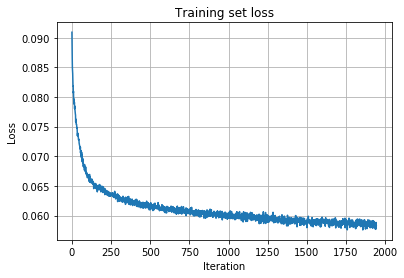

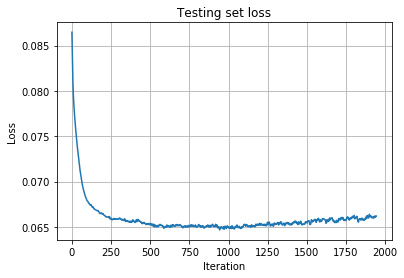

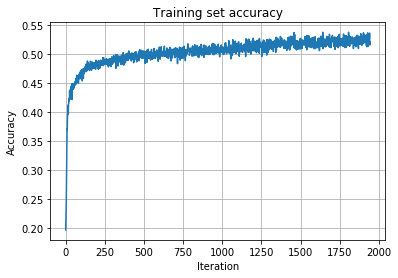

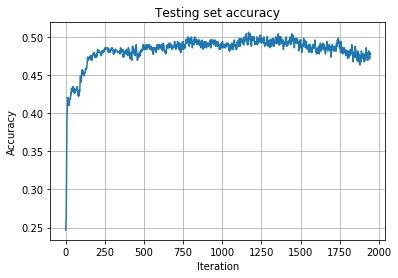

In [16]:
# Plotting loss
plt.figure(0)
plt.title("Training set loss")
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()

plt.figure(2)
plt.title("Testing set loss")
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()

# Plotting accuracy
plt.figure(1)
plt.title("Training set accuracy")
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()

plt.figure(3)
plt.title("Testing set accuracy")
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()

# Importing step1 model

This model can predict the result of a fight. It is not perfect, but it is far faster than actually simulate the fight through the game.

We will use it as our lost function for our reinforcment learning training


In [17]:
def step1_model(input_shape, output_shape):
    model = Sequential([
        lr.Dense(units=input_shape, activation='relu', input_dim=input_shape),
        lr.Flatten(),
        lr.Dropout(0.2),
        lr.Dense(units=56, activation='relu'),
        lr.Dropout(0.2),
        lr.Dense(units=28, activation='relu'),
        lr.Dropout(0.2),
        lr.Dense(units=14, activation='relu'),
        lr.Dropout(0.2),
        lr.Dense(units=7, activation='relu'),
        lr.Dense(units=output_shape, activation='tanh')
    ])

    model.compile(optimizer=opt.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0000001),
              loss="mean_absolute_error",
              metrics=['accuracy'])
    return model

In [18]:
step1_model = step1_model(56, 1)
step1_model.load_weights(os.path.join("data", "Models", "model_0.1343982719605969_step1.h5"))

OSError: Unable to open file (unable to open file: name = 'data/Models/model_0.1343982719605969_step1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Training a simple model

## Defining model 

The API used is tensorflow.keras as it is powerful and easy to use.

The model itself only has Dense layers since there is no spacial information yet


In [ ]:
model = create_model(X_data_step2[0].shape[0], 9)

## Defining Reinforcement Learning parameters

Taken from one of keras-rl GitHub's page example : https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py

In [ ]:
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor, Env
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import gym

In [ ]:
# Not done yet, but implement Processor and Environment following the link bellow
#https://github.com/keras-rl/keras-rl/blob/216c3145f3dc4d17877be26ca2185ce7db462bad/rl/core.py#L515
class CustomProcessor(Processor):
    def process_observation(self, observation):
        return observation
    
    def process_state_batch(self, batch):
        return batch
    
    def process_reward(self, reward):
        return reward

class CustomEnvironment(Env):
    def step(self, action):
        return action
    
    def seed(self, seed=None):
        return 0

In [ ]:
env = CustomEnvironment()
np.random.seed(123)
env.seed(123)

In [ ]:
memory = SequentialMemory(limit=1000000, window_length=4)
processor = CustomProcessor()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.,
                              value_min=.1, value_test=.05, nb_steps=1000000)
nb_actions = 1000

In [ ]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])

## Training the model

First, there is a check on the availability of a GPU. If you have an NVIDIA GPU on your computer, make sure CUDA 10.0, 10.1 and 10.2 are installed, are they are used by tensorlflow.

In [ ]:
NB_STEPS = 1000000

In [ ]:
# Training Model on GPU if available
list_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(list_devices))
print("Using GPU: ", list_devices[0] if len(list_devices) > 0 else False)

In [ ]:
# Training model_tilte_1
device = tf.device('/GPU:0') if len(list_devices) > 0 else tf.device('/CPU:0')
with tf.device('/GPU:0'):
    history = dqn.fit(env, callbacks=callbacks, nb_steps=NB_STEPS)

## Evaluating the model

This should be done directly through the game.

## Saving the current model

In [ ]:
dqn.save_weights('data/Models/model_step2.h5')
print("Saved model.")